In [9]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, '../../')

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier



from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')



RendererRegistry.enable('default')

In [10]:
full_model_data = ModelDataLoader('002')
full_model_data.df.to_csv('output.csv', index=False) 

In [11]:
data_df = pd.read_csv('/Users/tetyananesdill/music_modeling_capstone/notebooks/data_creation/output.csv')

# Examine the data & features

## Check missing values

In [12]:
missing_data = data_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']

missing_chart = alt.Chart(missing_data).mark_bar().encode(
    x='Column:N',
    y='Missing Count:Q',
    color = 'Missing Count:Q'
).properties (title='# of missing values', height=300, width=750)

missing_chart

alt.Chart(...)

## Train - Test Split 

In [13]:
y = data_df['label']
x = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)

## Check correlation between variables

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_55437/175155180.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = train_df.corr()


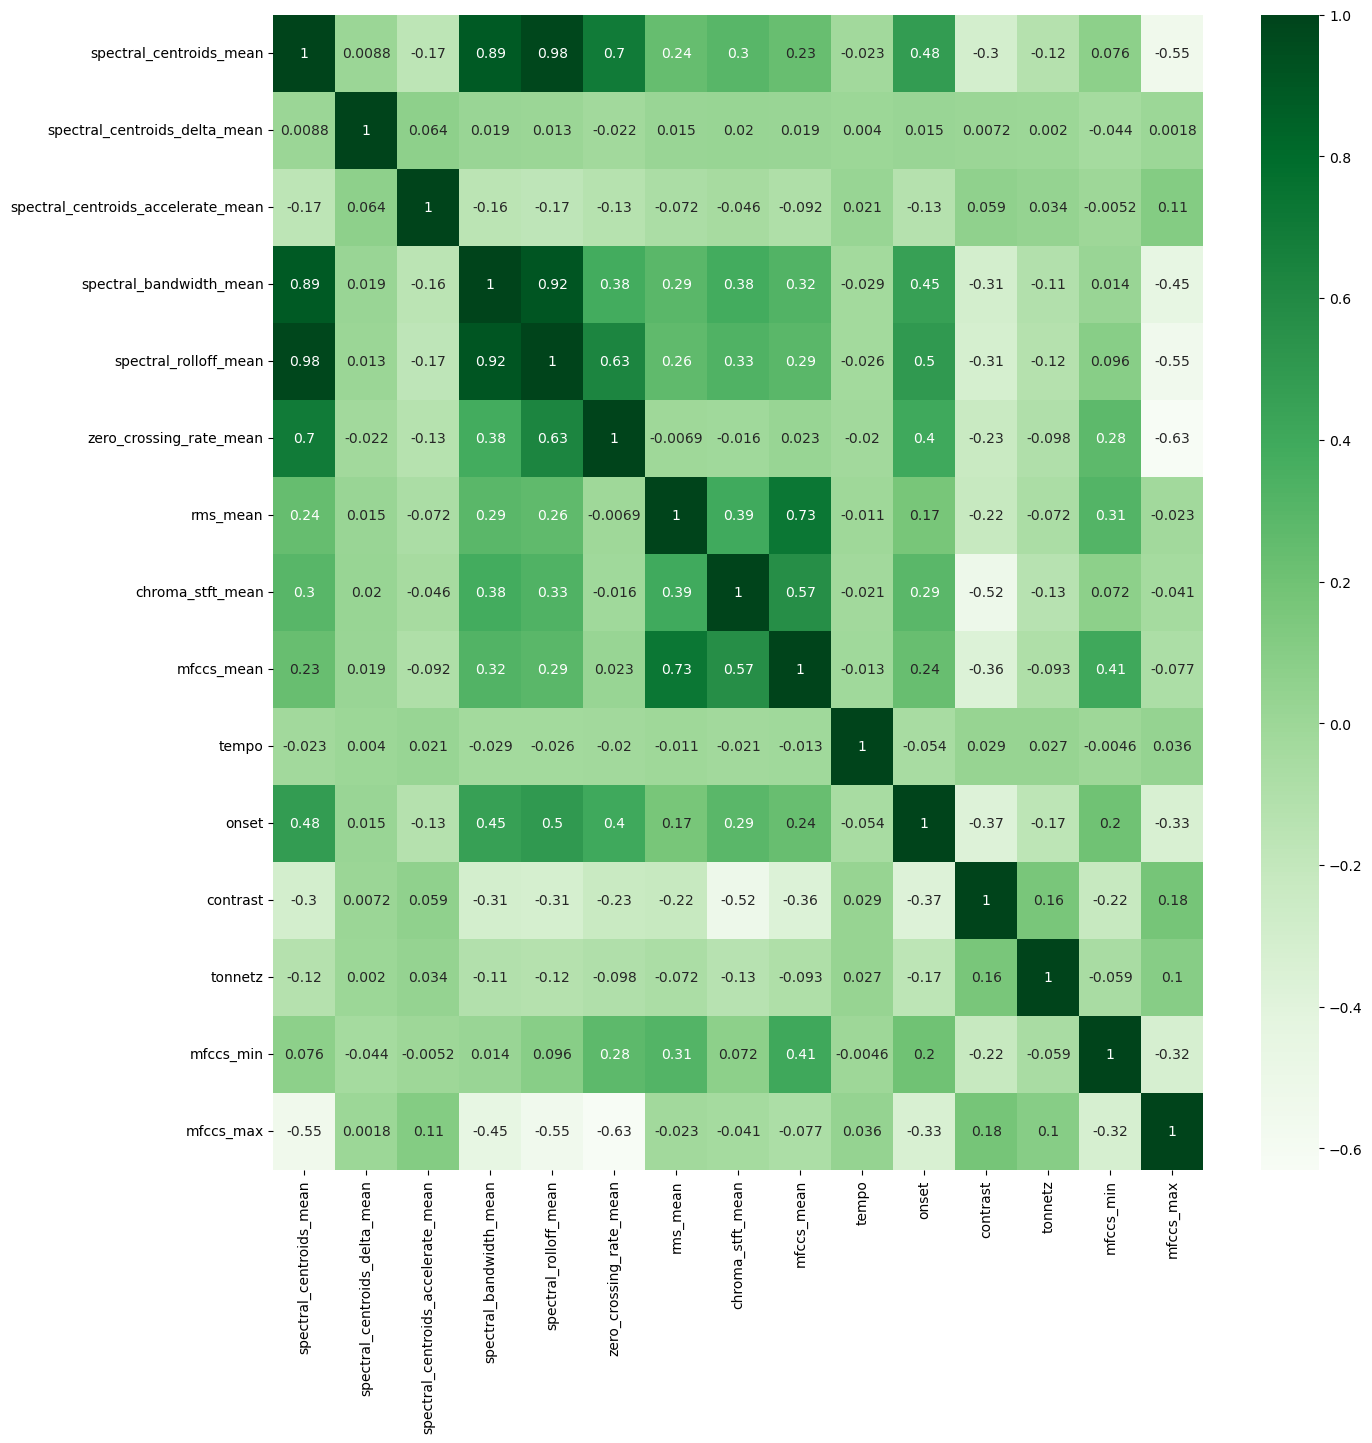

In [14]:
# check correlation between vars
matrix = train_df.corr()

plt.figure(figsize=(15, 15))

heatmap = sns.heatmap(matrix, cmap="Greens", annot=True)

plt.show()


certain features are highly correlated; we might want to take a note of that as it might be important depending on what algorithm we use. 

spectral bandwidth; spectral roll off; spectral centroids are highly correlated 

## Check var distribution be genre 

In [25]:
def box_plot(y_col):
    chart = alt.Chart(train_df).mark_boxplot(extent="min-max").encode(
        alt.X("label:N", title=None),
        alt.Y(y_col, title=None).scale(zero=False),
        alt.Color("label:N").legend(None),
    ).properties(title=y_col)
    return chart

#box_plot('sspectral_centroids_mean:Q') & box_plot('rms_mean') &  box_plot('mfccs_mean')| box_plot('spectral_centroids_delta_mean') & box_plot('spectral_centroids_accelerate_mean') & box_plot('spectral_rolloff_mean') | box_plot('zero_crossing_rate_mean') & box_plot('chroma_stft_mean') & box_plot('spectral_bandwidth_mean')


In [28]:
#new vars
box_plot('tempo') & box_plot('tonnetz')  | box_plot('onset') & box_plot('contrast') | box_plot('mfccs_mean') & box_plot('mfccs_max')

alt.HConcatChart(...)

two variables (spectral_centroids_accelerate and spectral_centroids_delta) do not show much variablity by genre. These variables might not be the best predictors of a genre. Consider exluding these two variables and maybe picking different ones. 


## Distribution by var and genre 

In [17]:
selection = alt.selection_multi(fields=['label'])
color = alt.condition(selection,
                      alt.Color('label:N', legend=None),
                      alt.value('lightgray'))

opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))


scatter = alt.Chart(train_df).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color=color,
    opacity=opacity,
    tooltip='label:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['tonnetz', 'contrast', 'tempo', 'onset'],
    column=['onset','tempo', 'contrast','tonnetz']
)

legend = alt.Chart(train_df).mark_point().encode(
    y=alt.Y('label:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

(scatter | legend)

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_55437/4044878086.py:1: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_multi(fields=['label'])
/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_55437/4044878086.py:26: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.HConcatChart(...)

it seems that some of these genres are all over the place.. hypothetically, it would be nice to see more of a pattern. but if you select such genres as 'experimental', it seems to be all over the place .. 

## Check class distribution 

In [18]:
class_dis = pd.DataFrame(train_df['label'].value_counts(normalize=True) * 100).reset_index()

alt.Chart(class_dis).mark_bar().encode(
    x=alt.X('label:Q', title=None),
    y=alt.Y('index:N', sort='-x', title=None),
    color='label:Q')

alt.Chart(...)

the classes are imbalanced, which might need to be remediated for a classificaiton algorithm. Minority class might not be correctly predicted. 

## Calculate distance between groups based on chroma_shift

In [19]:
sampled_df = train_df.groupby('label').sample(n=70)

def ec_distance(group1, group2):
    distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(group1, group2)]))
    return distance


genres = train_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = sampled_df[sampled_df['label']==i]['tempo']
        group2 = sampled_df[sampled_df['label']==j]['tempo']
        
        if i==j: 
            continue
        if (j,i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i,j] = round(dist,2)
        
dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(), columns=['genres', 'similarity']).head(20)
dist_df_top20

genres  similarity
0        (experimental, soulrnb)      151.85
1        (instrumental, soulrnb)      167.05
2   (experimental, instrumental)      170.36
3                (jazz, soulrnb)      170.74
4           (folk, experimental)      172.66
5                (folk, soulrnb)      177.62
6           (jazz, experimental)      180.21
7             (folk, electronic)      184.49
8           (classical, soulrnb)      184.88
9      (experimental, classical)      188.35
10           (pop, experimental)      192.73
11    (experimental, electronic)      194.61
12         (electronic, soulrnb)      195.65
13                (pop, soulrnb)      200.99
14          (folk, instrumental)      201.02
15          (experimental, rock)      203.11
16     (instrumental, classical)      204.03
17                  (folk, jazz)      204.77
18               (rock, soulrnb)      210.19
19          (jazz, instrumental)      212.21

Text(0.5, 1.0, 'Most similar genre based on the tempo feature')

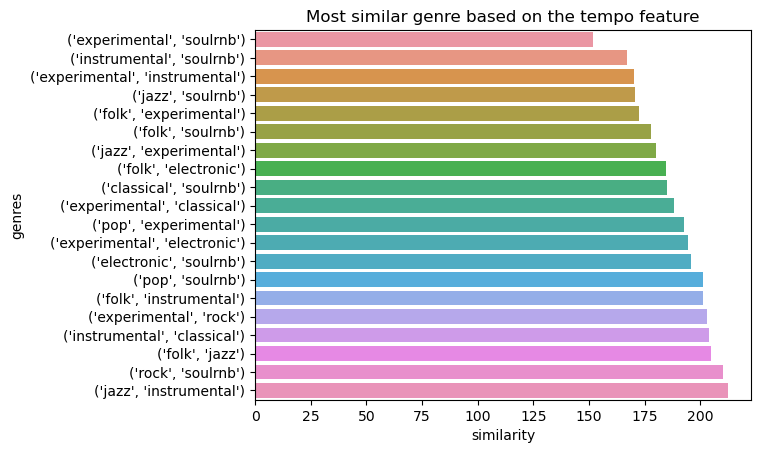

In [20]:
sns.barplot(x = 'similarity',
            y = 'genres',
            data = dist_df_top20)

plt.title("Most similar genre based on the tempo feature")